# WILO: 
Run the beta estimation for three states (currently I have only 3) so I can re-run the figures below

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn import preprocessing
from scipy.stats.mstats import winsorize
from matplotlib.ticker import StrMethodFormatter
from regimeaware.routines import cfg
from datetime import datetime
from regimeaware.core.methodologies import RegimeWeightedLS
from tqdm import tqdm
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

dt = datetime(2023, 12, 31)

cfg.data_fldr = r"C:\Users\franc\My Drive\bin\regimeaware\data"

ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl').loc[:dt, cfg.factor_set]
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')

In [3]:
mcap = crsp['shrout'].mul(crsp['prc'].abs()).xs(dt)
mcap_sorted = mcap.sort_values(ascending= False)
mcap_coverage = mcap_sorted.cumsum().div(mcap.sum())
mcap_flags = mcap_coverage < .999
size_ids = mcap_flags[mcap_flags].index
active_ids = rt.reindex(size_ids, axis=1).iloc[-1].dropna().index
n_obs = rt[active_ids].count()
sample_ids = n_obs[n_obs > 24].index
print(f'Number of active stocks: {len(sample_ids)}')

Number of active stocks: 2718


BIC = -2*logLike + num_free_params * log(num_of_data)

In [4]:
n = 2

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

mdl = GaussianHMM(
    n_components=n,
    covariance_type="diag",
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.fit(X)

Model is not converging.  Current: 8179.002600846255 is not greater than 8179.249532065123. Delta is -0.2469312188686672


GaussianHMM(implementation='scaling', n_components=2, random_state=123, tol=0.1)

\begin{aligned}
-\frac{n}{2}\log SSR
                  -\frac{n}{2}\left(1+\log\left(\frac{2\pi}{n}\right)\right)
                  -\frac{1}{2}\log\left(\left|W\right|\right)
\end{aligned}

In [5]:
n = 2

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

mdl = GaussianHMM(
    n_components=n,
    covariance_type="diag",
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.fit(X)


g = pd.DataFrame(mdl.predict_proba(X), index=ff.index, columns=range(n))

collect_betas = {}
collect_resid = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id].dropna()
    rwls = RegimeWeightedLS(endog=y, exog=X, emission_prob=g)
    rwls.fit(add_constant=True)

    collect_betas[sec_id] = rwls.params.stack()
    collect_resid[sec_id] = rwls.resid.var(ddof=0)


Model is not converging.  Current: 8179.002600846255 is not greater than 8179.249532065123. Delta is -0.2469312188686672
100%|██████████| 2718/2718 [00:25<00:00, 106.21it/s]


\begin{aligned}
BIC = k \log \left( n \right) - 2 \log \left( \hat{L} \right)
\end{aligned}

In [6]:
"""
I'm adding up the BIC for now, but there is an issue with the number of observations. The loglikelihood
of stocks with longer time series will be higher, so the BIC will be lower. I need to adjust for that.
I also need to adjust for the number of regimes (and total number of parameters) in the model.
"""
collect_mdl_llf = {}
collect_mdl_bic = {}

for n_states in range(1, 6):
    Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
    X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

    hmm = GaussianHMM(
        n_components=n_states,
        covariance_type="diag",
        random_state=cfg.hm_rs,
        min_covar=cfg.hm_min_covar,
        tol=cfg.hm_tol,
        implementation=cfg.hm_implementation
    )
    hmm.fit(X)


    g = pd.DataFrame(hmm.predict_proba(X), index=ff.index, columns=range(n_states))

    collect_llf = {}
    collect_bic = {}

    for sec_id in tqdm(Y.columns, desc=f"{n_states} states"):
        y = Y[sec_id].dropna()

        _llf = 0
        _bic = 0
        for s in range(n_states):
            w = g[s].reindex(y.index)
            mdl = sm.WLS(y, sm.add_constant(X.reindex(y.index)), weights=w)
            _llf += mdl.fit().llf
            _bic += mdl.fit().bic

        collect_llf[sec_id] = _llf
        collect_bic[sec_id] = _bic

    collect_mdl_llf[n_states] = pd.Series(collect_llf)
    collect_mdl_bic[n_states] = pd.Series(collect_bic)

1 states: 100%|██████████| 2718/2718 [00:10<00:00, 256.78it/s]
Model is not converging.  Current: 8179.002600846255 is not greater than 8179.249532065124. Delta is -0.2469312188695767
5 states: 100%|██████████| 2718/2718 [00:52<00:00, 51.66it/s]


In [7]:
hmm._get_n_fit_scalars_per_param()

{'s': 4, 't': 20, 'm': 25, 'c': 25}

In [8]:
len(cfg.factor_set)

5

In [9]:
k = sum(hmm._get_n_fit_scalars_per_param().values())

In [10]:
# nobs2 = self.nobs / 2.0
# SSR = np.sum((self.wendog - np.dot(self.wexog, params))**2, axis=0)
# llf = -np.log(SSR) * nobs2      # concentrated likelihood
# llf -= (1+np.log(np.pi/nobs2))*nobs2  # with constant
# llf += 0.5 * np.sum(np.log(self.weights))

In [11]:
np.sum(w)

172.19367020975267

In [12]:
n

2

In [13]:
s = 0
ssr = np.sum(rwls.resid[s] ** 2)
n = len(y)
w = g[s].reindex(y.index)

-n / 2 * np.log(ssr) - n / 2 * (1 + np.log(2 * np.pi / n)) + 1 /2 * np.sum(np.log(w))

-1064.3241771689045

In [14]:
mdl = sm.WLS(y, sm.add_constant(X.reindex(y.index)), weights=w)
mdl.fit().llf

-669.2936071809598

In [15]:
mdl.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  80577   R-squared:                       0.144
Model:                            WLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     9.470
Date:                Tue, 25 Mar 2025   Prob (F-statistic):           2.33e-08
Time:                        08:07:38   Log-Likelihood:                -669.29
No. Observations:                 287   AIC:                             1351.
Df Residuals:                     281   BIC:                             1373.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0601      0.036      1.648      0.100      -0.012       0.132
mktrf         -1.6814      0.547     -3.076      0.002      -2.758      -0.605
smb            1.5249      0.589      2.589      0.010       0.366       2.684
hml            0.2526      0.754      0.335      0.738      -1.231       1.736
rmw           -3.3561      0.653     -5.142      0.000      -4.641      -2.071
cma           -2.7515      1.010     -2.724      0.007      -4.740      -0.763
==============================================================================
Omnibus:                      121.070   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9568.947
Skew:                           0.705   Prob(JB):                         0.00
Kurtosis:                      31.252   Cond. No.                         60.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
mdl.fit(cov_type="HAC", cov_kwds={'maxlags': 12}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  80577   R-squared:                       0.144
Model:                            WLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     2.490
Date:                Tue, 25 Mar 2025   Prob (F-statistic):             0.0316
Time:                        08:07:38   Log-Likelihood:                -669.29
No. Observations:                 287   AIC:                             1351.
Df Residuals:                     281   BIC:                             1373.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0601      0.068      0.880      0.379      -0.074       0.194
mktrf         -1.6814      1.462     -1.150      0.250      -4.546       1.183
smb            1.5249      1.405      1.085      0.278      -1.230       4.279
hml            0.2526      2.021      0.125      0.901      -3.708       4.213
rmw           -3.3561      1.646     -2.039      0.041      -6.582      -0.131
cma           -2.7515      3.206     -0.858      0.391      -9.036       3.533
==============================================================================
Omnibus:                      121.070   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9568.947
Skew:                           0.705   Prob(JB):                         0.00
Kurtosis:                      31.252   Cond. No.                         60.0
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
"""

In [17]:
mdl.fit().params

const    0.060089
mktrf   -1.681397
smb      1.524906
hml      0.252592
rmw     -3.356149
cma     -2.751532
dtype: float64

In [18]:
n = 3

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()

mdl = GaussianHMM(
    n_components=n,
    covariance_type="diag",
    random_state=cfg.hm_rs,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.fit(X)


g = pd.DataFrame(mdl.predict_proba(X), index=ff.index, columns=range(n))

collect_betas = {}
collect_resid = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id].dropna()
    mdl = RegimeWeightedLS(endog=y, exog=X, emission_prob=g)
    mdl.fit(add_constant=True)

    collect_betas[sec_id] = mdl.params.stack()
    collect_resid[sec_id] = mdl.resid.var(ddof=0)

100%|██████████| 2718/2718 [00:37<00:00, 72.42it/s] 


In [19]:
mdl.covars_

AttributeError: 'RegimeWeightedLS' object has no attribute 'covars_'

## Recovery

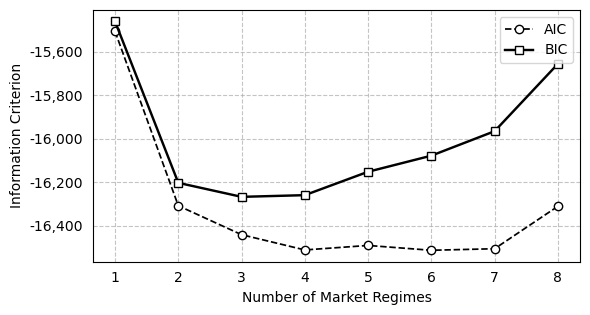

In [ ]:
states_to_try = range(1, 9)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)

# trn_raw = ff.copy()
# scaler = preprocessing.StandardScaler(copy=True).fit(trn_raw)
# trn = scaler.transform(trn_raw)
trn = ff.copy()

collect_mdls = {}

for n in states_to_try:
    mdl = GaussianHMM(
        n_components=n,
        covariance_type="diag",
        random_state=999,
        min_covar=cfg.hm_min_covar,
        tol=cfg.hm_tol,
        implementation=cfg.hm_implementation
    )
    mdl.fit(trn)
    _score = mdl.bic(trn)
    collect_mdls[_score] = mdl
    bic[n] = _score
    aic[n] = mdl.aic(trn)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3.25))
plot_map = {'AIC': (aic, '--', 1.25, 'o'), 'BIC': (bic, '-', 1.75, 's')}

for label, params in plot_map.items():
    ax.plot(params[0], color='k', marker=params[3], mfc='white', lw=params[2], ls=params[1])
    ax.grid(ls='--', alpha=.75)

# ax.set_title('Information Criterion', weight='bold')
ax.set_ylabel('Information Criterion')
ax.set_xlabel('Number of Market Regimes')
ax.legend(['AIC', 'BIC'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', bottom=False, left=False)
plt.tight_layout()
plt.show()


In [ ]:
mdl = collect_mdls[min(collect_mdls)]
n_states = mdl.n_components
print(f'Number of states: {n_states}')

hm_mu = mdl.means_
hm_sigma = mdl.covars_
hm_transmat = mdl.transmat_
hm_start_p = mdl.startprob_
hm_post_p = mdl.predict_proba(X=trn)

Number of states: 3


In [ ]:
res_var = pd.Series(index=pd.MultiIndex.from_tuples([(dt, x) for x in sample_ids], names=['date', 'id']))

Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()
g = pd.DataFrame(hm_post_p, index=ff.index, columns=range(n_states))
B = pd.DataFrame(index=ff.index, columns=ff.columns)

collect_betas = {}
collect_resid = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id].dropna()
    mdl = RegimeWeightedLS(endog=y, exog=X, emission_prob=g)
    mdl.fit(add_constant=True)

    collect_betas[sec_id] = mdl.params.stack()
    collect_resid[sec_id] = mdl.resid.var(ddof=0)


state_betas = pd.DataFrame.from_dict(collect_betas)
state_betas.index.names = ['param', 'state']
state_var = pd.DataFrame(collect_resid)
state_var.index.name = "state"

100%|██████████| 2718/2718 [00:13<00:00, 206.12it/s]


In [ ]:
Y = rt.loc[cfg.trn_start_dt:dt, sample_ids].copy()
X = ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].copy()
X = sm.add_constant(X)

collect_betas = {}
collect_var = {}

for sec_id in tqdm(Y.columns):
    y = Y[sec_id]
    cmn_idx = X.join(y).dropna().index
    mdl = sm.OLS(y.reindex(cmn_idx), X.reindex(cmn_idx))
    mdl_fit = mdl.fit()

    collect_betas[sec_id] = mdl_fit.params.copy()
    collect_var[sec_id] = mdl_fit.mse_resid

ols_var = pd.Series(collect_var)
ols_betas = pd.DataFrame(collect_betas)

100%|██████████| 2718/2718 [00:02<00:00, 933.28it/s]


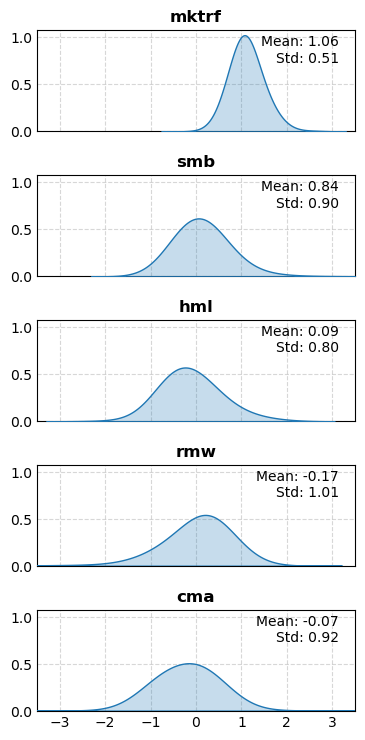

In [ ]:
# Empirical distribution of factor loadings
fig, axs = plt.subplots(nrows=len(cfg.factor_set), ncols=1, figsize=(3.75, len(cfg.factor_set) * 1.5), sharex=True, sharey=True)
for i, fact in enumerate(cfg.factor_set):
    _vals = ols_betas.xs(fact).to_frame().join(mcap.to_frame('mcap'))
    _vals[fact] = winsorize(_vals[fact], limits=[.01, .01]).data
    
    _mu = _vals[fact].mean()
    _sigma = _vals[fact].std()
    
    ax = axs.flatten()[i]
    ax.text(.95, .95, f'Mean: {_mu:.2f}\nStd: {_sigma:.2f}', ha='right', va='top', transform=ax.transAxes)
    sns.kdeplot(data=_vals, x=fact, ax=ax, bw_adjust=2, fill=True, zorder=25, weights='mcap')
    ax.set_title(fact, weight='bold')
    ax.grid(ls='--', alpha=.5, zorder=-25)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim(-3.5, 3.5)
    ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout()
plt.show()

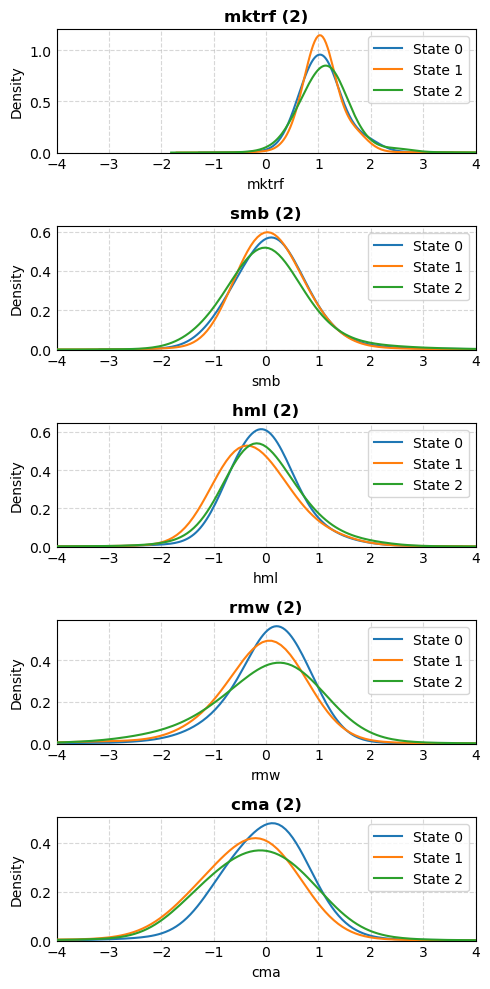

In [ ]:
# Empirical distribution of factor loadings
fig, axs = plt.subplots(nrows=len(cfg.factor_set), ncols=1, figsize=(5, len(cfg.factor_set) * 2), sharex='row', sharey='row')
collect_params = {}
for i, fact in enumerate(cfg.factor_set):
    ax = axs[i]
    for m in range(n_states):
        _vals = state_betas.xs(fact).xs(m).to_frame(fact).join(mcap.to_frame('mcap'))
        _vals[fact] = winsorize(_vals[fact], limits=[.01, .01]).data
        sns.kdeplot(data=_vals, x=fact, ax=ax, bw_adjust=1.5, fill=False, zorder=25, weights='mcap')
        collect_params[(fact, m)] = (_vals[fact].mean(), _vals[fact].std())

    ax.legend([f"State {x}" for x in range(n_states)], loc='upper right')
    ax.set_title(f"{fact} ({m})", weight='bold')
    ax.axvline(np.mean(_vals), c='firebrick')
    ax.grid(ls='--', alpha=.5, zorder=-25)
    ax.set_xlim(-4, 4)
    ax.tick_params(axis='both', which='both', length=0)

plt.tight_layout()

In [ ]:
hm_mu = mdl.means_
hm_sigma = mdl.covars_
hm_transmat = mdl.transmat_
hm_start_p = mdl.startprob_
hm_post_p = mdl.predict_proba(X=trn)

In [ ]:
hm_mu

array([[-0.03155466, -0.00655743,  0.03622326,  0.00773049,  0.02853216],
       [ 0.00996672,  0.00285796, -0.00019117,  0.00266319, -0.00010355],
       [ 0.03632159,  0.01142133, -0.02979366, -0.00402662, -0.01956764]])

In [ ]:
mdl = GaussianHMM(
    n_components=n_states,
    covariance_type="diag",
    random_state=999,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol,
    implementation=cfg.hm_implementation
)
mdl.means_ = hm_mu
mdl.transmat_ = hm_transmat
mdl.startprob_ = hm_start_p
mdl.means_ = hm_mu
mdl.fit(ff)

# TODO:
The point of using the historical data should be 

1. Have an idea of how many regimes are there taking the 5-factor model (3 states?)
1. Given these m-states, what are the distributions of these factors, are they statistically different?
1. What are the state-dependent parameters of these distributions? (to be used in the simulations)
1. Given these m-states simulate long paths for the hidden states
1. Simulate synthetic returns for n stocks, drawing the betas from the corresponding distributions 

In [ ]:
startprob = np.array([0.6, 0.3, 0.1, 0.0])
transmat = np.array(
    [
        [0.7, 0.2, 0.0, 0.1],
        [0.3, 0.5, 0.2, 0.0],
        [0.0, 0.3, 0.5, 0.2],
        [0.2, 0.0, 0.2, 0.6]
    ]
)

means = np.array(
    [
        [0.0, 0.0],
        [0.0, 11.0],
        [9.0, 10.0],
        [11.0, -1.0]
    ]
)

covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
gen_model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
gen_model.startprob_ = startprob
gen_model.transmat_ = transmat
gen_model.means_ = means
gen_model.covars_ = covars

# Generate samples
X, Z = gen_model.sample(500)

Z

array([0, 1, 1, 2, 2, 2, 1, 1, 2, 3, 3, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0, 0,
       1, 1, 1, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 1, 0, 1, 0, 0, 1,
       1, 1, 2, 2, 2, 1, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 2,
       2, 3, 3, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 2, 2, 2,
       2, 2, 1, 0, 0, 0, 0, 0, 3, 3, 3, 0, 0, 3, 2, 1, 2, 2, 1, 2, 2, 2,
       3, 2, 2, 2, 1, 1, 2, 2, 2, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 0,
       0, 3, 3, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 2, 2, 1, 1, 0, 0, 0, 0, 3, 3, 3, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 2, 1, 2, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [ ]:
pd.DataFrame(gen_model.predict_proba(X)).round(4)  # The probability of each state at each time point is pretty much either 0 or 1

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
...,...,...,...,...
495,0.0,1.0,0.0,0.0
496,1.0,0.0,0.0,0.0
497,1.0,0.0,0.0,0.0
498,1.0,0.0,0.0,0.0


In [ ]:
np.tile(np.identity(2), (2, 1, 1))

In [ ]:
startprob = np.array([1, 0])
transmat = np.array(
    [
        [0.85, 0.15],
        [0.4, 0.6],
    ]
)

means = np.array(
    [
        [0.1],
        [-0.1],
    ]
)

covars = np.array([1, 1]).reshape(-1, 1)

# Build an HMM instance and set parameters
gen_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", random_state=12345)

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
gen_model.startprob_ = startprob
gen_model.transmat_ = transmat
gen_model.means_ = means
gen_model.covars_ = covars

# Generate samples
X, Z = gen_model.sample(120)

Z

In [ ]:
transmat = np.array(
    [
        [0.85, 0.15],
        [0.4, 0.6],
    ]
)
np.linalg.matrix_power(transmat, 9999999).T @ np.array([1, 0]).reshape(-1, 1)